<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/11_Feature_learning/11_4_Cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 11: Principles of Feature Learning

# 11.4 Naive Cross-Validation

Validation error provides us with a concrete way of not only measuring the performance of a single tuned model, but more importantly it allows us to compare the efficacy of multiple tuned models of various levels of complexity.  By carefully searching through a set of models ranging in complexity we can then easily identify the best of the bunch, the one that provides minimal error on the validation set. This comparison of models, called *cross-validation* or sometimes *model search* or *selection*, is the basis of feature learning as it provides a systematic way to *learn* (as opposed to *engineer*, as detailed in Chapter 10) the proper form a nonlinear model should take for a given dataset.

In this Section we introduce what we refer to as *naive* cross-validation.  This consists of a search over a set of models of *varying capacity*, with each model fully optimized over the training set, in search of a validation error-minimizing choice.   While it is simple in principle and in implementation, naive cross-validation is generally speaking very expensive (computationally speaking) and often results in a rather *coarse* model search that can miss (or 'skip over') the ideal amount of complexity desired for a given dataset. 

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_11_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_datasets
    else:
        print('chapter_11_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_11_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_library
    else:
        print('chapter_11_library already cloned!')

    # clone images
    if not Path('chapter_11_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_images
    else:
        print('chapter_11_images already cloned!')

    # clone videos
    if not Path('chapter_11_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/11_Feature_learning/chapter_11_videos
    else:
        print('chapter_11_videos already cloned!')
        

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_11_library') 

# backend file
import section_11_4_helpers
import intro_general_library

# data path
data_path_1 = 'chapter_11_datasets/noisy_sin_sample.csv'
data_path_2 = 'chapter_11_datasets/new_circle_data.csv'

# image paths
image_path_1 = "chapter_11_images/Figure_11_28.png"
image_path_2 = "chapter_11_images/Figure_11_31.png"

# video paths
video_path_1 = 'chapter_11_videos/animation_6.mp4'
video_path_2 = 'chapter_11_videos/animation_7.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
import autograd.numpy as np
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

##  The big picture

The first *organized* approach one might take to determining an ideal amount of complexity for a given dataset is to first choose a single universal approximator (e.g., one of those simple exemplars outlined in Section 11.2.3) and construct a set of models $M$ models of the general form by ranging the value of $B$ from $1$ to $M$ sequentially as

\begin{equation}
\begin{array}
\
\text{model}_1\left(\mathbf{x},\Theta_1\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1}   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,      \,\,\,  \,\,    \\
\text{model}_2\left(\mathbf{x},\Theta_2\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2}   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,   \,\,\,  \,\,   \\
\,\,\,\,\,  \,\,\,\,\, \,\,\,\,\, \,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,\vdots  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,    \\
\text{model}_M\left(\mathbf{x},\Theta_M\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_M\left(\mathbf{x}\right)w_M.
\end{array}
\label{equation:naive-cross-validation-model-set}
\end{equation}

This set of models - which we can denote compactly as $\left\{ \text{model}_m\left(\mathbf{x},\Theta_m\right)_{m=1}^M \right\}$ (or even more compactly as just $\left\{\text{model}_m\right\}_{m=1}^M$)  where the set $\Theta_m$ consists of all those parameters of the $m^{th}$ model $\text{model}_m$ -  naturally *increases* in *capacity* from $m=1$ to $m=M$ (as first described in Section 11.2.3).  If we *optimize* every one of these models to completion they will also roughly speaking - as discussed in Section 11.3 -  increase in terms of their *complexity with respect to training data* as well.  Thus, if we first split our original data randomly into training and validation portions as detailed in Section 11.3.4, and measure the error of all $M$ fully trained models on each portion of the data, we can very easily determine which of the $M$ models provides the ideal amount of complexity for the dataset overall by finding the one that achieves *minimum validation*. 

---

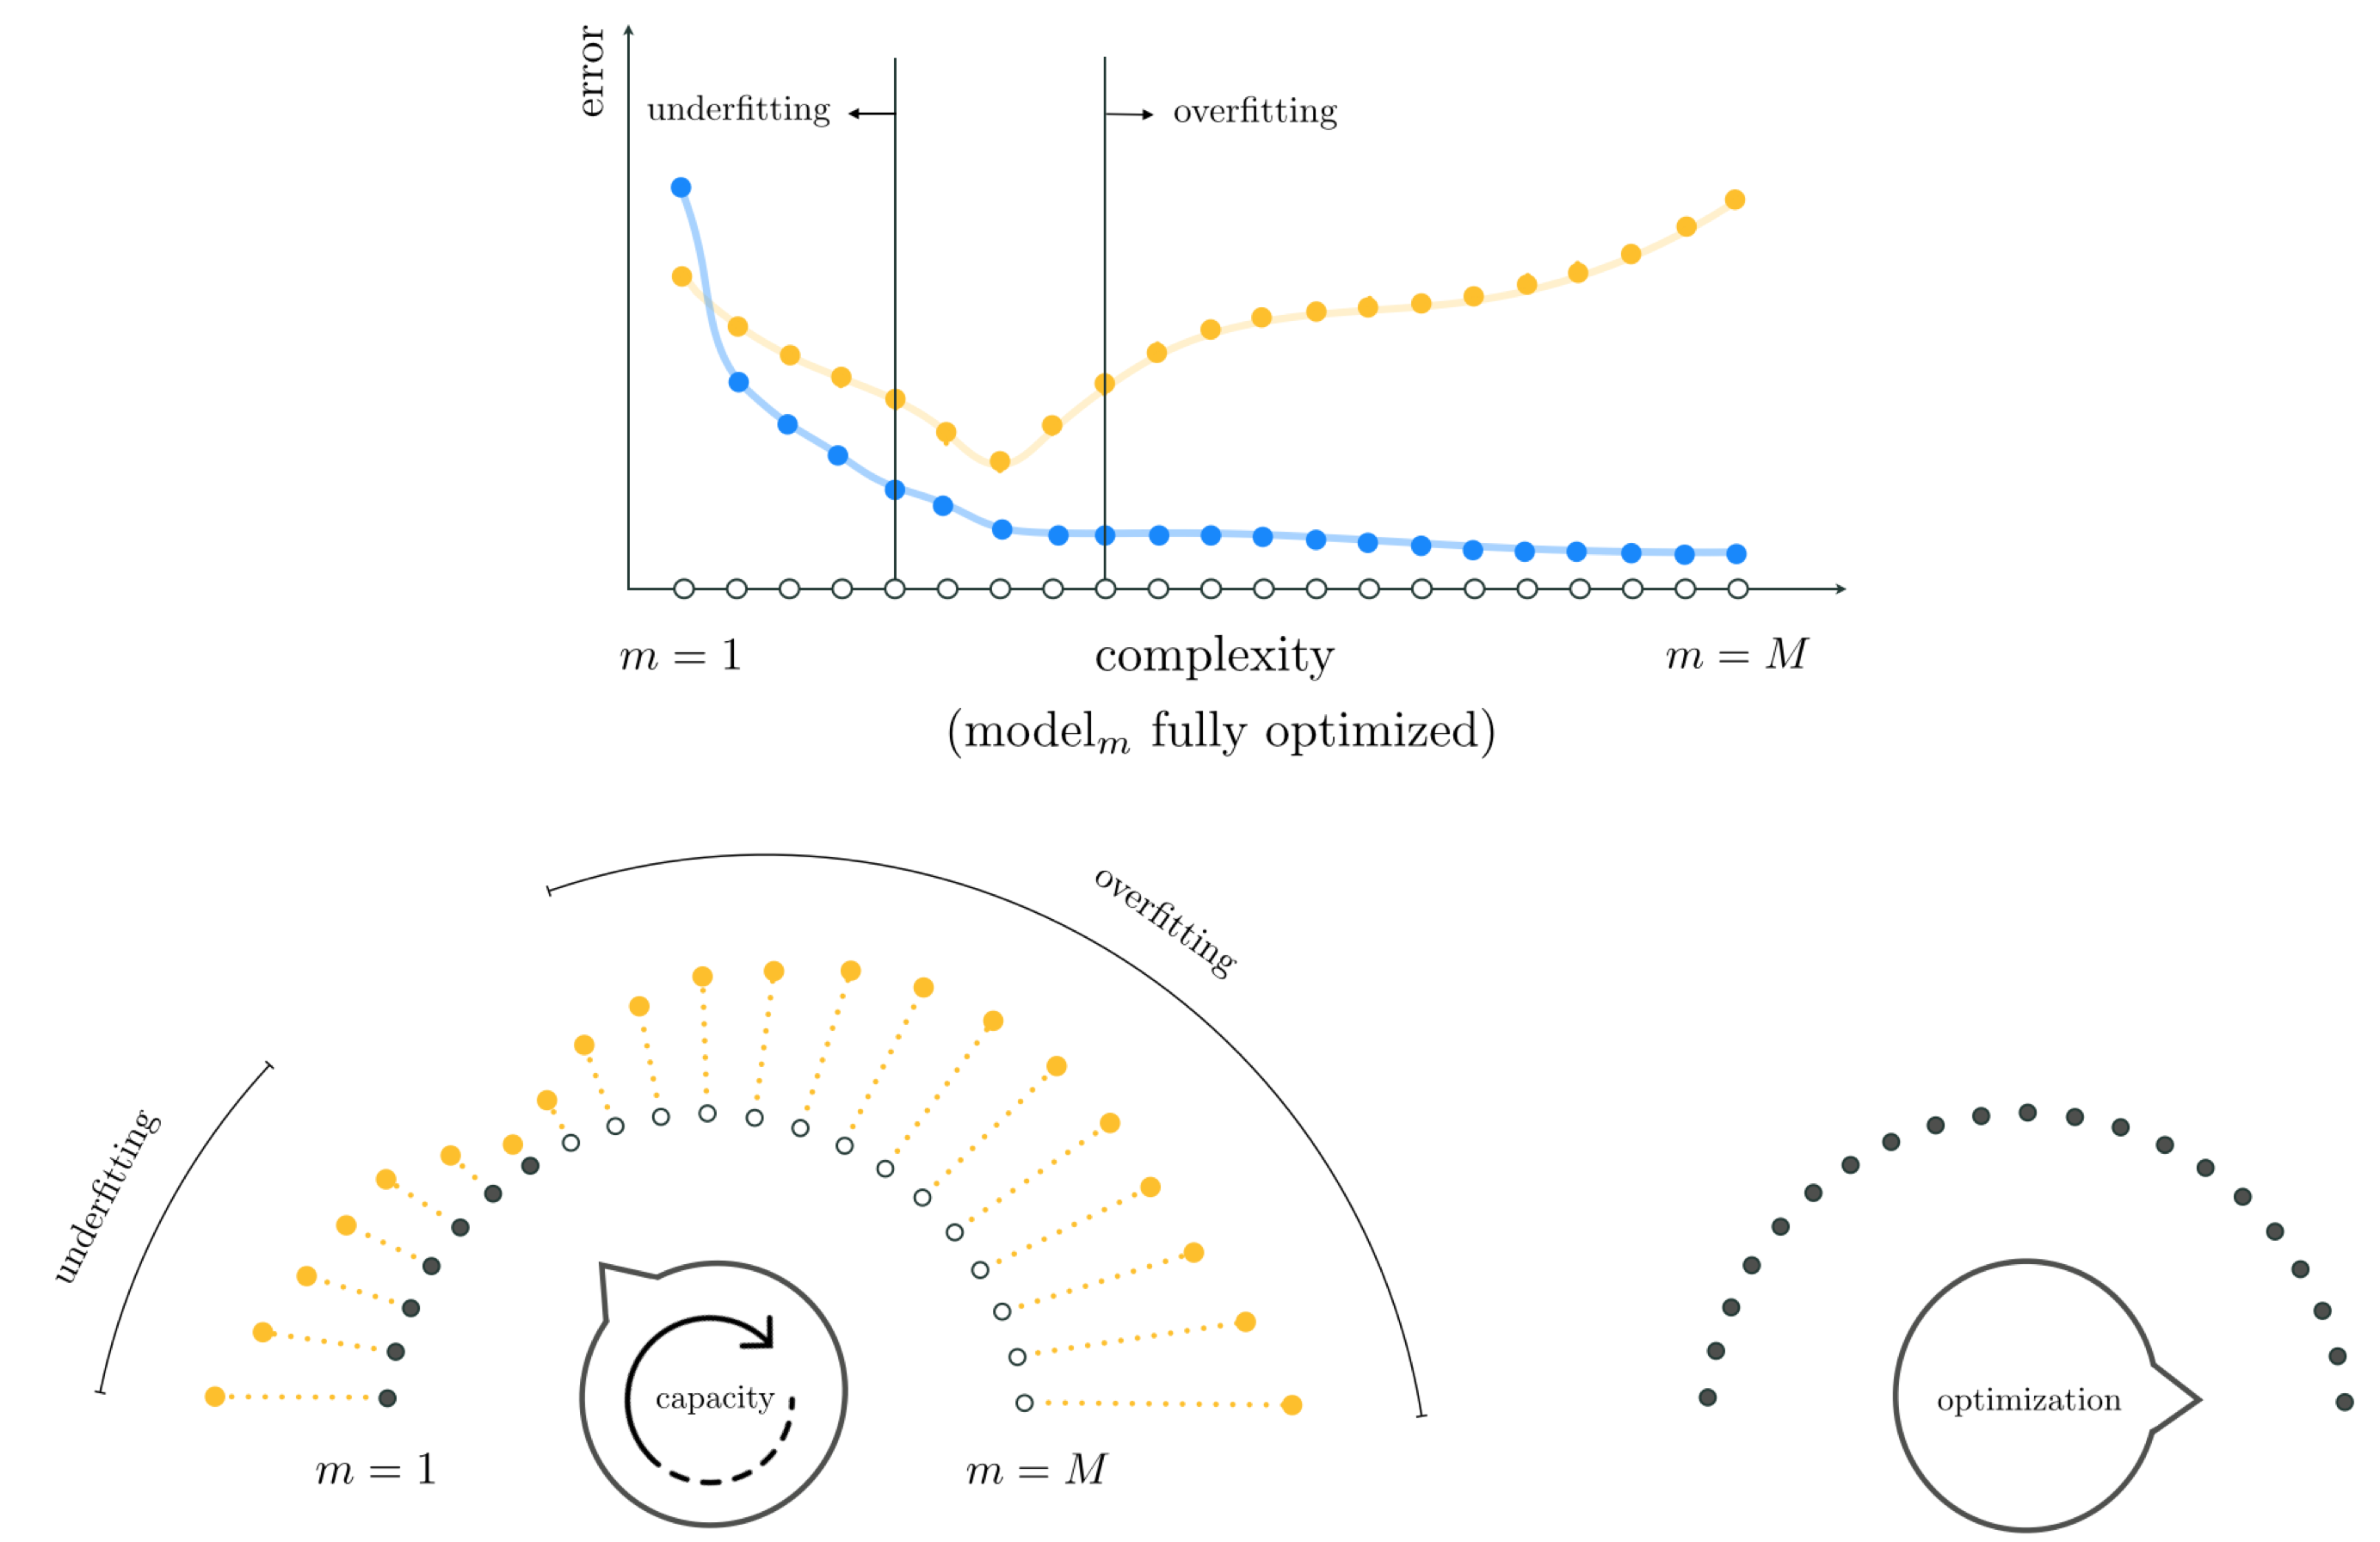

In [2]:
Image(image_path_1)

<a id='figure-11-28'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.28 </strong> <em> 
(top panel) A prototypical training (in blue) and validation (in yellow) error plots resulting from a prototypical run of naive cross-validation.  Here the set of models - which generally increase in complexity with respect to the training set - are formed by fully optimizing a set of models of increasing capacity. Low complexity models underfit the data, typically producing large training and validation errors. While the training error will monotonically decrease as model complexity increases, validation error tends to decrease only up to the point where overfitting of the training data begins. (lower panels) Naive cross-validation using our dial conceptualization - where we turn the capacity dial from left-to-right, searching over a range of models of increasing capacity in search of a validation error minimizing model, while keeping the optimization dial set all the way to the right (indicating that we optimize each model to completion). See text for further details.
</em>
</figcaption>
</figure>

---

In the top panel of [Figure 11.28](#11.28) we show the generic sort of training (in blue) and validation (in yellow) errors we find in practice as a result of following this naive cross-validation scheme. The horizontal axis of this plot shows (roughly speaking) the complexity of each of our $M$ *fully optimized* models, with the output on the vertical axis denoting error level.  As can be seen in the Figure, our low complexity models *underfit* the data as reflected in their high training and validation errors. As the model complexity increases further, fully optimized models achieve lower training error since increasing model complexity allows us to constantly improve how well we can represent training data. This fact is reflected in the monotonically decreasing nature of the (blue) training error curve. On the other hand, while the validation error of our models will tend to decrease at first as we increase complexity, this trend continues only up to a point where *overfitting* of the training data begins. Once we reach a model complexity that overfits the training data our validation error starts to increase again, as our model becomes less and less a fair representation of "data we might receive in the future" generated by the same phenomenon.  

Note in practice that while training error typically follows the monotonically decreasing trend shown in the top panel of Figure 11.28, validation error can oscillate up and down more than once depending on the models tested.  In any event, we determine the best fully optimized model from the set by choosing the one that *minimizes* validation error.  This is often referred to as solving the *bias-variance trade-off*, as it involves determining a model that (ideally) neither underfits (or has high bias) nor overfits (or has high variance). 

In the bottom row of [Figure 11.28](#figure-11-28) we summarize this naive approach to cross-validation using the capacity / optimization dial conceptualization first introduced in Section 11.3.2.  Here we set our *optimization* dial all the way to the right - indicating that we optimize every model to completion - and in ranging over our set of $M$ models we turn the *capacity* dial from left to right starting with $m=1$ (on the left) and ending with $m=M$ (all the way to the right - with the value of $m$ increasing by $1$ at each notch of the dial).  Since in this case the *capacity* dial roughly governs model complexity - as summarized visually in the bottom row of Figure 11.24 -  our model search reduces to setting this dial correctly to the minimum validation error setting.  To visually denote how this is done we wrap the prototypical validation error curve shown in the top panel of [Figure 11.28](#figure-11-28) clockwise around the capacity dial.  We can then imagine setting this dial correctly (and automatically) to the value of $m$ providing minimum validation error.

#### <span style="color:#a50e3e;">Example 11.9:</span>  Naive cross-validation and regression

In this example we illustrate the use of a naive cross-validation procedure on the sinusoidal regression dataset.  Here we use $\frac{2}{3}$ of the original set of $21$ data points for training, and the remaining $\frac{1}{3}$ for validation. The set of models we compare here are polynomials of degree $1 \leq m \leq 8$. In
other words, the $m^{th}$ model from our set  $\left\{\text{model}_m\right\}_{m=1}^8$ is a single-input degree $m$ polynomial of the form

\begin{equation}
\text{model}_m\left(\mathbf{x},\Theta_m\right) = w_0 + x{w}_{1} +  x^2{w}_{2} + \cdots + x^m{w}_m.
\end{equation}

Note how this small set of models is naturally ordered in terms of nonlinear capacity, with lower degree models having smaller capacity (being capable of producing low complexity tuned models only) and larger degree models having higher capacity (being capable of producing tuned models ranging from low to high complexity, depending on how their parameters are tuned).

In the animation below we show the fit of each polynomial model (from degree $1$ to $8$) on the original dataset (first row), training data (second row), and validation data (third row). The errors on both the training (in blue) and validation (in yellow) data is shown in the
bottom panel. Notice, the validation error is at its lowest when the model is a degree $3$ polynomial. Of course as we use more polynomial units, moving from left to right in the Figure, the higher degree models fit the training data better. However as the training error continues to decrease, the corresponding validation error starts climbing rapidly as the corresponding models provide poorer and poorer representations of the validation data (by the time $m = 7$ the validation error becomes so large that we do not plot it in the same window so that the other error values can be
distinguished properly).

---

In [ ]:
# # run demonstration - uncomment to re-render animation
# demo3 = section_11_4_helpers.SingleVisualizer()
# demo3.load_data(data_path_1)
# demo3.brows_single_cross_val(savepath=video_path_1,basis='poly',num_elements = [v for v in range(1,9)],folds = 3,fps=1)

In [3]:
show_video(video_path_1)

---

#### <span style="color:#a50e3e;">Example 11.10:</span>   Naive cross-validation and classification

In this example we illustrate the use of a naive approach to cross-validation on a toy two-class classification dataset. Here we use (approximately) $\frac{4}{5}$ of the original set of $99$ data points for training, and the other $\frac{1}{5}$ for validation. For the sake of simplicity we employ only a small set of polynomial models having degrees $1 \leq m \leq 7$. In other words, the $m^{th}$ model from our set  $\left\{\text{model}_m\right\}_{m=1}^7$ is a degree $m$ polynomial (with $N=2$ dimensional input) of the form

\begin{equation}
\text{model}_m\left(\mathbf{x},\Theta_m\right) = w_0 + \sum_{i+j\,\leq \, m} w_{i,\,j}\,x_1^{\,i}x_2^{\,j}.
\end{equation}

These models are also naturally ordered from low to high capacity, as we increase the degree $m$ of the polynomial.

In the animation below we show the fit of each model along with the original data (first row), the training data (second row), and the validation data (third row). The training and validation errors are likewise shown in the bottom panel. With classification it makes more sense to use the number of misclassifications computed over the training/validation sets or some function of these misclassifications (e.g., accuracy) as our training/validation errors, as opposed to the raw evaluation of a classification cost.

In this case the degree $m = 2$ polynomial model provides the smallest validation error, and hence the best nonlinear decision
boundary for the entire dataset.  As the complexity goes up and training error continues to decrease, our models overfit the training data while at the same time providing a poor solution for the validation data.

---

In [ ]:
# # load in dataset
# data = np.loadtxt(data_path_2,delimiter = ',')
# x = data[:-1,:]
# y = data[-1:,:] 

# ### run cross validation experiments ###
# degrees = np.arange(1,8)
# models_1 = []
# for j in degrees:
#     # import the v1 library
#     mylib1 = intro_general_library.superlearn_setup.Setup(x,y)

#     # choose features
#     mylib1.choose_features(name = 'polys',degree = j)
    
#     # choose normalizer
#     mylib1.choose_normalizer(name = 'none')

#     # split into training and testing sets
#     mylib1.make_train_valid_split(train_portion = 0.66)

#     # choose cost
#     mylib1.choose_cost(name = 'softmax')

#     # fit an optimization
#     mylib1.fit(optimizer = 'newtons_method',max_its = 5,epsilon = 10**(-8))

#     # add model to list
#     models_1.append(mylib1)

# # load up animator
# demo2 = section_11_4_helpers.CrossvalClassificationVisualizer(data_path_2)

# # animate based on the sample weight history
# demo2.animate_crossval_classifications(video_path_2,models_1,fps=1)

In [4]:
show_video(video_path_2)

---

## Problems with naive cross-validation

Naive cross-validation works reasonably well for simple examples like those described above, and is cheap computationally speaking.  However since the process generally involves trying out a range of models - whether it be an organized set consisting of models that monotonically increase in capacity / number of units or some more general collection of models - where each model is *optimized completely*, naive cross-validation can be very expensive computationally speaking.  Moreover, the *capacity* difference between even adjacent models (e.g., those consisting of $m$ and $m+1$ units) can be quite large - even if *low capacity* units are used (as each additional unit 'adds an additional dimension' to the span of the model - as illustrated conceptually in Figure 11.7).  While there are certainly special cases when the capacity of a set of models can be controlled *smoothly*, typically since each model is fully optimized this can lead to huge jumps in the range of model complexities tried out on a dataset.  In other words naive cross-validation often leads to a very *coarse* range of model complexities that can 'miss out' on an ideal amount of nonlinearity for a given dataset.  

This general 'coarse search resolution' problem is illustrated conceptually in [Figure 11.31](#figure-11-31).  Controlling model complexity search via adjustment of the *capacity* dial (with our optimization dial turned all the way to the right - as depicted in the bottom panels of [Figure 11.31](#figure-11-31) often only allows for a *coarse* model search that can easily 'skip over' an ideal amount of (validation error minimizing) model complexity.  In short, generally speaking, performing model search via the adjustment of the *capacity dial* is expensive and results in a coarse search for validation error minimizing complexity.  As we will see in the next two Sections, much more robust and fine-grained cross-validation schemes can be constructed by setting our *capacity dial* to the right and controlling model *complexity* by carefully setting our *optimization dial*.

---

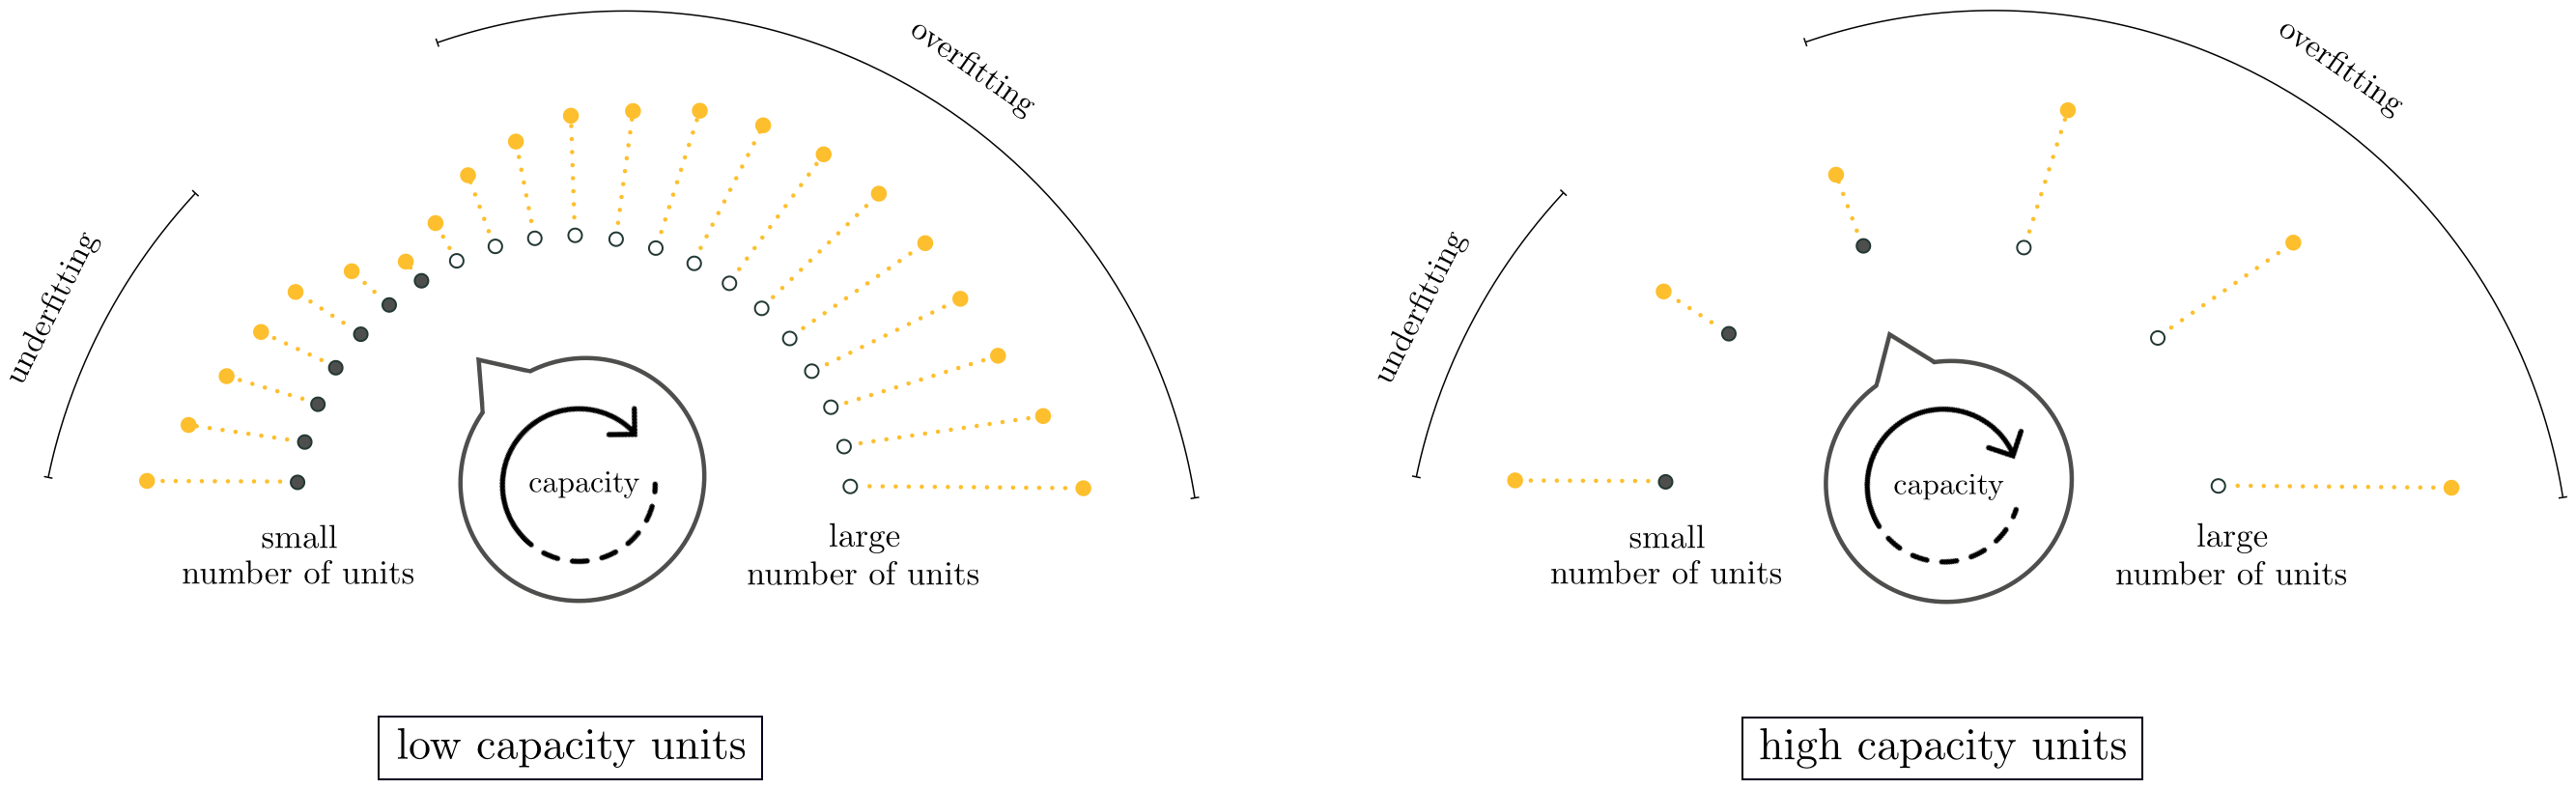

In [5]:
Image(image_path_2)

<a id='figure-11-31'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.31 </strong> <em> 
Naive cross-validation depicted as the proper adjustment of the capacity dial.  While ideally we would like the resolution of our search to be fine-grained (as depicted in the left panel) often times it results - due to the very nature of the approach -  in a rather coarse search for validation error minimizing models (as depicted in the right panel - where large turns of the capacity dial easily skip over the validation error minimizing choice).
</em>
</figcaption>
</figure>

---